## 1. Importación de librerías

In [18]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 2. Función de métricas auxiliar

In [19]:
def calcular_metricas(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    smape = 100 * np.mean(2 * np.abs(pred - real) / (np.abs(real) + np.abs(pred)))
    mape = 100 * np.mean(np.abs((real - pred) / real))
    r2 = r2_score(real, pred)
    metricas = pd.DataFrame({
        'Métrica': ['MAE', 'RMSE', 'sMAPE', 'MAPE', 'R2'],
        'Valor': [mae, rmse, f"{smape:.2f}%", f"{mape:.2f}%", f"{r2:.2f}"]
    })
    return metricas

## 3. Carga de datos

In [20]:
df = pd.read_csv('../output/dataset_venta.csv')
df['fecha'] = pd.to_datetime(df['fecha'], format="%Y-%m-%d", errors='coerce')
df = df.groupby('fecha')['monto_recibido'].sum().reset_index()
df.rename(columns={'fecha':'ds','monto_recibido':'y'}, inplace=True)
df = df.sort_values('ds').reset_index(drop=True)
df.head(10)

,ds,y
0,2019-01-07,5651.05
1,2019-01-08,4285.00
2,2019-01-09,15455.00
3,2019-01-10,5024.50
4,2019-01-11,6350.50
5,2019-01-12,2741.00
6,2019-01-14,4213.00
7,2019-01-15,3204.00
8,2019-01-16,3838.00
9,2019-01-17,4065.00


## 4. División del dataset

In [21]:
n = len(df)
train_size = int(n*0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(train)}")
print(f"Tamaño del conjunto de prueba: {len(test)}")
print(f"Fechas de entrenamiento: {train['ds'].min().date()} a {train['ds'].max().date()}")
print(f"Fechas de prueba: {test['ds'].min().date()} a {test['ds'].max().date()}")


Tamaño del conjunto de entrenamiento: 1544
Tamaño del conjunto de prueba: 386
Fechas de entrenamiento: 2019-01-07 a 2024-05-07
Fechas de prueba: 2024-05-08 a 2025-08-18


## 5. Entrenamiento del modelo

In [22]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_mode='multiplicative'
)
m.add_seasonality(name='mensual', period=30.5, fourier_order=5)
m.fit(train)

22:37:47 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing


## 6. Predicciones

In [23]:
future = pd.concat([train[['ds']], test[['ds']]]).reset_index(drop=True)
forecast = m.predict(future)

predicciones = forecast.iloc[-len(test):]

In [24]:
calcular_metricas(test['y'].values, predicciones['yhat'].values)

,Métrica,Valor
0,MAE,535.771351
1,RMSE,729.239391
2,sMAPE,30.97%
3,MAPE,37.25%
4,R2,0.09


## 7. Gráficos

In [25]:
line_real = dict(color='#000000', linewidth=1.2, label='Datos reales')
line_pred = dict(color='#1f77b4', linewidth=1.2, linestyle='--', label='Predicción')
fill_pred = dict(color='#1f77b4', alpha=0.1, label='Intervalo 95%')
grid_opts = dict(linestyle='--', alpha=0.25)

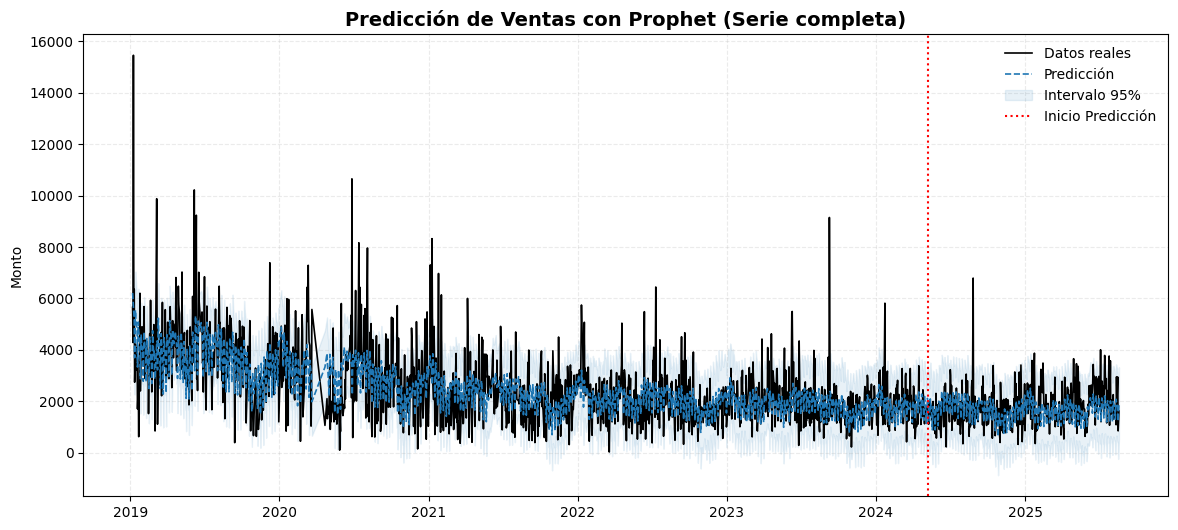

In [26]:
plt.figure(figsize=(14,6))
plt.plot(df['ds'], df['y'], **line_real)
plt.plot(forecast['ds'], forecast['yhat'], **line_pred)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], **fill_pred)
plt.axvline(df['ds'].iloc[train_size], color='red', linestyle=':', linewidth=1.5, label='Inicio Predicción')
plt.title('Predicción de Ventas con Prophet (Serie completa)', fontsize=14, weight='bold')
plt.ylabel('Monto')
plt.grid(**grid_opts)
plt.legend(frameon=False)
plt.show()

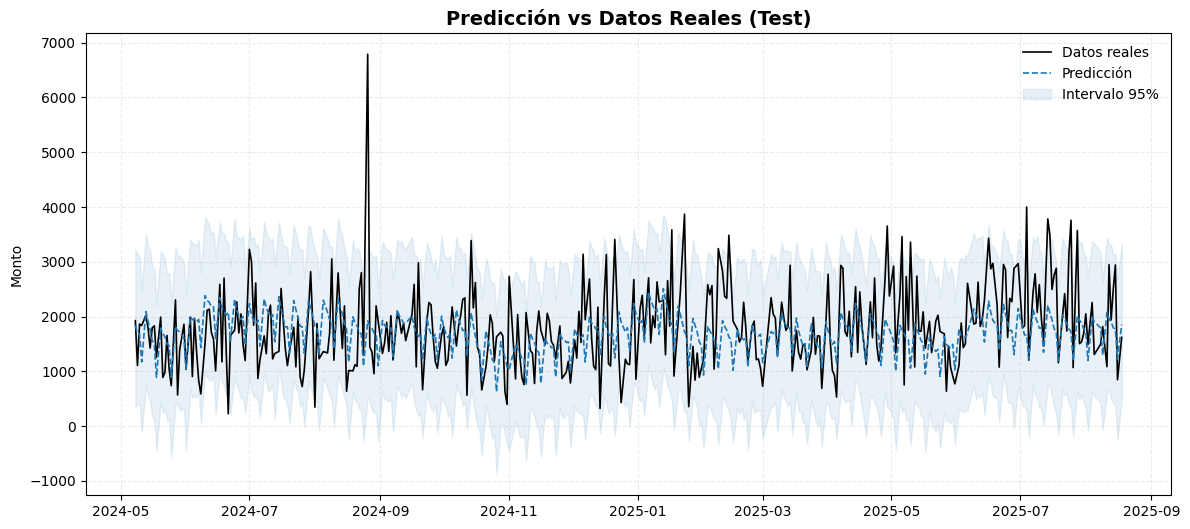

In [27]:
plt.figure(figsize=(14,6))
plt.plot(test['ds'], test['y'], **line_real)
plt.plot(predicciones['ds'], predicciones['yhat'], **line_pred)
plt.fill_between(predicciones['ds'], predicciones['yhat_lower'], predicciones['yhat_upper'], **fill_pred)
plt.title('Predicción vs Datos Reales (Test)', fontsize=14, weight='bold')
plt.ylabel('Monto')
plt.grid(**grid_opts)
plt.legend(frameon=False)
plt.show()

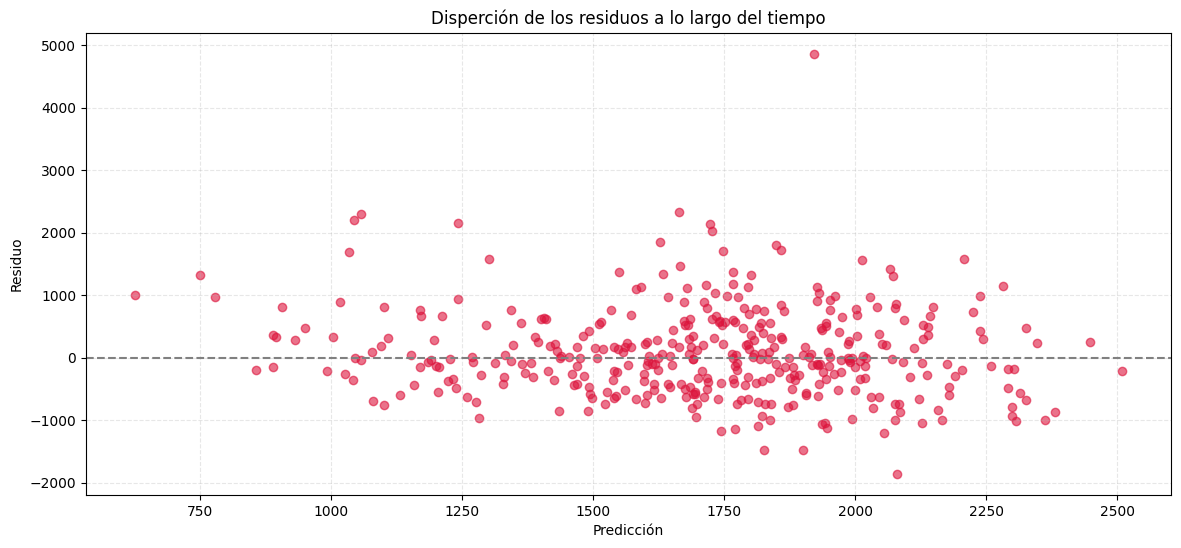

In [28]:
residuos = test['y'].values - predicciones['yhat'].values

plt.figure(figsize=(14,6))
plt.scatter(predicciones['yhat'], residuos, alpha=0.6, color='crimson')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Disperción de los residuos a lo largo del tiempo")
plt.xlabel('Predicción')
plt.ylabel('Residuo')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


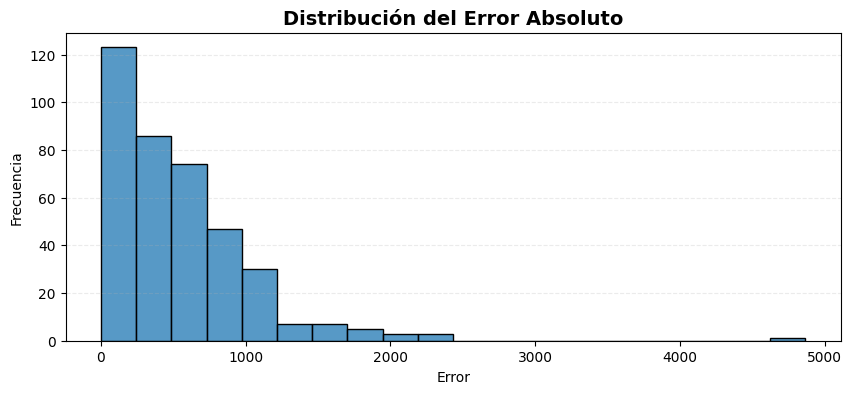

In [29]:
plt.figure(figsize=(10,4))
sns.histplot(abs(residuos), bins=20, color='#1f77b4', edgecolor='black')
plt.title('Distribución del Error Absoluto', fontsize=14, weight='bold')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.show()

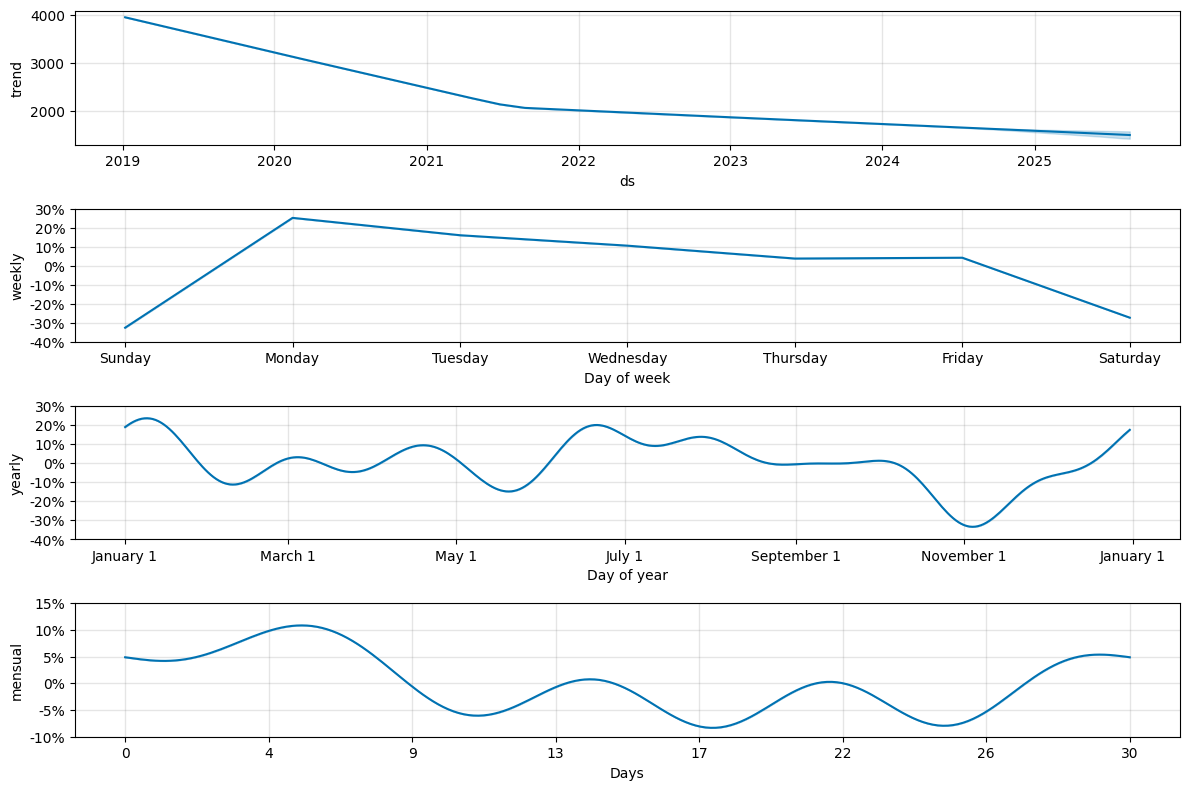

In [30]:
fig = m.plot_components(forecast)

fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

In [31]:
resultado = pd.DataFrame({
    'ds': test['ds'].values,
    'real': test['y'].values,
    'yhat': predicciones['yhat'].values,
    'yhat_lower': predicciones['yhat_lower'].values,
    'yhat_upper': predicciones['yhat_upper'].values,
    'residuo': residuos
})
resultado.head(10)

,ds,real,yhat,yhat_lower,yhat_upper,residuo
0,2024-05-08,1925.0,1836.555002,345.186008,3214.443216,88.444998
1,2024-05-09,1107.0,1691.473328,410.498380,3146.652498,-584.473328
2,2024-05-10,1864.0,1687.797773,395.221680,3095.214008,176.202227
3,2024-05-11,1835.6,1171.509183,-109.995096,2489.928376,664.090817
4,2024-05-13,2023.0,2091.031236,735.371975,3505.076427,-68.031236
5,2024-05-14,1796.0,1917.667160,570.007540,3283.354716,-121.667160
6,2024-05-15,1425.0,1766.588177,452.148551,3213.305780,-341.588177
7,2024-05-16,1794.6,1565.302458,168.566263,2913.208083,229.297542
8,2024-05-17,1830.5,1481.906826,116.234319,2861.681023,348.593174
9,2024-05-18,1253.5,889.882598,-447.496297,2215.011341,363.617402


In [32]:
resultado.to_csv(f'../output/prediccion_prophet.csv', index=False)
print(f"Archivo exportado: prediccion_prophet_diario_mejorado.csv")

Archivo exportado: prediccion_prophet_diario_mejorado.csv


## 8. Subir modelo a HuggingFace

In [34]:
import pickle

with open('../output/modelo_prophet.pkl', 'wb') as f:
    pickle.dump(m, f)

print("Modelo guardado en output/modelo_prophet.pkl")

Modelo guardado en output/modelo_prophet.pkl
